In [1]:
import sys

In [3]:
# STEP 1: Import package code
%matplotlib inline
import os
import numpy as np
import cv2
from matplotlib import pyplot as plt
from plantcv import plantcv as pcv

In [7]:
# STEP 2: Set global variables
device = 0                                                               # Workflow step counter
debug = 'plot'                                                           # Plot debug images to the notebook
rgb_img = './examples/naive-bayes/arabidopsis-test.jpg'  # Image filename

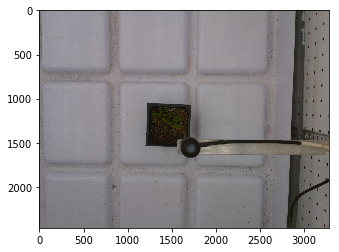

In [8]:
# STEP 3: Read RGB image and plot it to the notebook
# Inputs:
#    filename = name of image file
img, path, filename = pcv.readimage(rgb_img)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

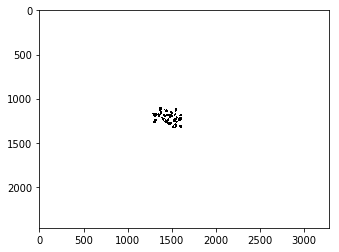

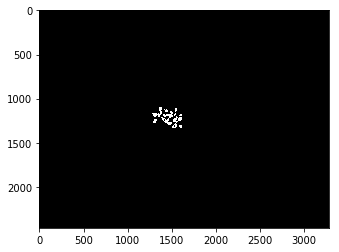

In [9]:
# STEP 3: use naive bayes
# Keep only the Saturation channel (grayscale)
# Inputs:
#    img     = image object, RGB colorspace
#    pdf_file = str): output file containing PDFs from plantcv-train.py
#    device  = device number. Used to count steps in the workflow
#    debug   = None, print, or plot. Print = save to file, Plot = print to screen.
device, mask = pcv.naive_bayes_classifier(img, "./examples/naive-bayes/naive_bayes_pdfs-arabidopsis.txt", device, debug)

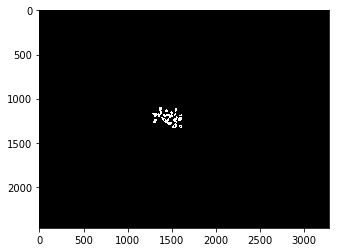

In [12]:
# STEP 5: Fill in small objects (speckles)
# Inputs:
#    img    = image object, grayscale. img will be returned after filling
#    mask   = image object, grayscale. This image will be used to identify contours
#    size   = minimum object area size in pixels (integer)
#    device = device number. Used to count steps in the pipeline
#    debug  = None, print, or plot. Print = save to file, Plot = print to screen.
mask1 = mask['plant']
mask2 = np.copy(mask1)
device, fill_image = pcv.fill(mask1, mask2, 50, device, debug)
#                                               ^
#                                               |
#                                               adjust this value

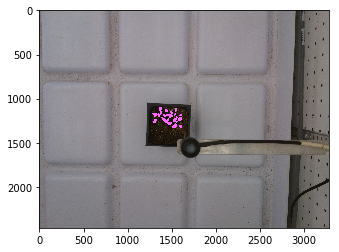

In [13]:
# STEP 8: Find objects (contours: black-white boundaries)
# Inputs:
#    img       = image that the objects will be overlayed
#    mask      = what is used for object detection
#    device    = device number.  Used to count steps in the pipeline
#    debug     = None, print, or plot. Print = save to file, Plot = print to screen.
device, id_objects, obj_hierarchy = pcv.find_objects(img, fill_image, device, debug)

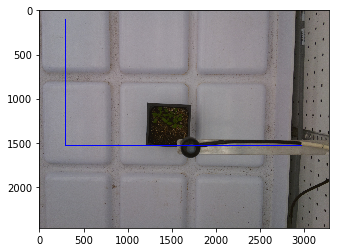

In [14]:
# STEP 9: Define region of interest (ROI)
# Inputs:
#    img       = img to overlay roi
#    roi       = default (None) or user input ROI image, object area should be white and background should be black,
#                has not been optimized for more than one ROI
#    roi_input = type of file roi_base is, either 'binary', 'rgb', or 'default' (no ROI inputted)
#    shape     = desired shape of final roi, either 'rectangle' or 'circle', if  user inputs rectangular roi but chooses
#                'circle' for shape then a circle is fitted around rectangular roi (and vice versa)
#    device    = device number.  Used to count steps in the pipeline
#    debug     = None, print, or plot. Print = save to file, Plot = print to screen.
#    adjust    = either 'True' or 'False', if 'True' allows user to adjust ROI
#    x_adj     = adjust center along x axis
#    y_adj     = adjust center along y axis
#    w_adj     = adjust width
#    h_adj     = adjust height
device, roi, roi_hierarchy = pcv.define_roi(img, 'rectangle', device, None, 'default', debug, True, 
                                             300, 100, -300, -925)
#                                            ^                ^
#                                            |________________|
#                                            adjust these four values

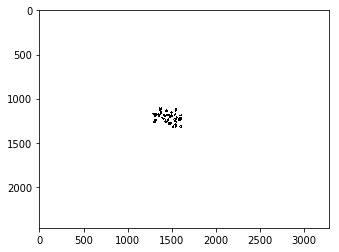

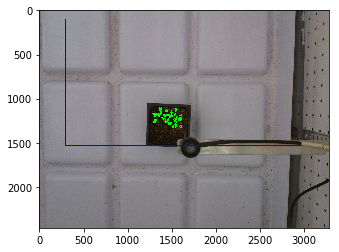

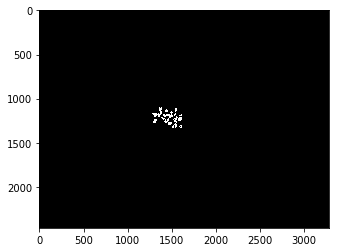

In [15]:
# STEP 10: Keep objects that overlap with the ROI
# Inputs:
#    img            = img to display kept objects
#    roi_type       = 'cutto' or 'partial' (for partially inside)
#    roi_contour    = contour of roi, output from "View and Ajust ROI" function
#    roi_hierarchy  = contour of roi, output from "View and Ajust ROI" function
#    object_contour = contours of objects, output from "Identifying Objects" fuction
#    obj_hierarchy  = hierarchy of objects, output from "Identifying Objects" fuction
#    device         = device number.  Used to count steps in the pipeline
#    debug          = None, print, or plot. Print = save to file, Plot = print to screen.
device, roi_objects, roi_obj_hierarchy, kept_mask, obj_area = pcv.roi_objects(img, 'partial', roi, roi_hierarchy,
                                                                           id_objects, obj_hierarchy, device,
                                                                           debug)

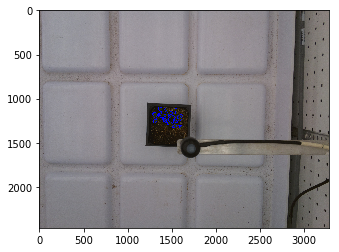

In [16]:
# STEP 11: Object combine kept objects
# Inputs:
#    contours = object list
#    device   = device number. Used to count steps in the pipeline
#    debug    = None, print, or plot. Print = save to file, Plot = print to screen.
device, obj, mask = pcv.object_composition(img, roi_objects, roi_obj_hierarchy, 
                                           device, debug)

In [17]:
# STEP 12: If you want to save output images set an outfile
outfile='./examples/naive-bayes/output/'+str(filename[:-4])+'-outfile'
print(outfile)

./examples/naive-bayes/output/arabidopsis-test-outfile


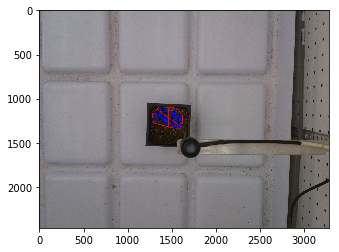

In [18]:
#STEP 13: Measure the area and other shape properties of the plant
# Inputs:
#    img             = image object (most likely the original), color(RGB)
#    imgname         = name of image
#    obj             = single or grouped contour object
#    device          = device number. Used to count steps in the pipeline
#    debug           = None, print, or plot. Print = save to file, Plot = print to screen.
#    filename        = False or image name. If defined print image
device, shape_header, shape_data, shape_img = pcv.analyze_object(img, rgb_img, obj, mask, device, debug,outfile)

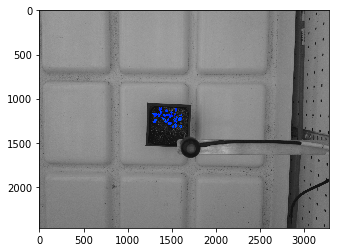

In [19]:
#STEP 15: Analyze color
#Inputs:
#    histogram       = a normalized histogram of color values from one color channel
#    bins            = number of color bins the channel is divided into
#    img             = input image
#    mask            = binary mask image
#    background      = what background image?: channel image (img) or white
#    channel         = color channel name
#    filename        = input image filename
#    resolution      = output image resolution
#    analysis_images = list of analysis image filenames
#    debug           = print or plot. Print = save to file, Plot = print to screen.

device, color_header,color_data,color_img= pcv.analyze_color(img,img, mask, 256, device, debug,None,'v','img',300,outfile)

In [16]:
#STEP 16: Write data headers and data out to a file

outputfile= './examples/naive-bayes/output/'+ str(filename[:-4]+'-results.txt')
result=open(outputfile,"a")
result.write('\t'.join(map(str,shape_header)))
result.write("\n")
result.write('\t'.join(map(str,shape_data)))
result.write("\n")
for row in shape_img:
    result.write('\t'.join(map(str,row)))
    result.write("\n")
result.write('\t'.join(map(str,color_header)))
result.write("\n")
result.write('\t'.join(map(str,color_data)))
result.write("\n")
result.write('\t'.join(map(str,boundary_header)))
result.write("\n")
result.write('\t'.join(map(str,boundary_data)))
result.write("\n")
result.write('\t'.join(map(str,boundary_img1)))
result.write("\n")
for row in color_img:
    result.write('\t'.join(map(str,row)))
    result.write("\n")
result.close()
